## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=500, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=15,     # Number of steps each sampled episode should contain
    batchSize=40,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=4.0, noiseLevel=0.05)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=2.0, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G2", basePower=2.0, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
#             GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.GAS, minPower=0.5, maxPower=2.0, noiseLevel=0.05),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='3Gens-CostFrequency-0_5k-c6'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
ElectricalConstants().droop = math.inf

Train Agents

In [6]:
def rewardFn(deltaFreq, totalCost):
    scaledCost = totalCost/(1000.0) # Scale down cost to levels near the ones found in output differential (e.g. 10 */ 10)
    costComponent = 2**(-1*(scaledCost**2)/50)
    freqComponent = 4*2**(-1*(deltaFreq**2)*8)+4*2**(-1*(deltaFreq**2)/2) + 2**(-1*(deltaFreq**2)/100)
    earnedReward = costComponent*freqComponent
    
    print(f'Scaled_Cost:{scaledCost} - deltaFreq:{deltaFreq} - costComponent:{costComponent} - freqComponent:{freqComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'freq': freqComponent, 'total': earnedReward}

In [7]:
from learning.cost_frequency import ModelAdapterCostFrequency as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [18]:
%%time
# allAgents = ModelTrainer(modelAdapter).trainAgents()
# Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/3Gens-CostFrequency-0_5k-c6/model
# CPU times: user 1h 39min 31s, sys: 10min 23s, total: 1h 49min 55s
# Wall time: 1h 22min 4s

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 31 µs


In [9]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

W0916 19:22:04.109884 140286301308672 deprecation.py:323] From /home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Scaled_Cost:3.46444278753197 - deltaFreq:3.4087089867345526 - costComponent:0.8467175652989225 - freqComponent:0.9939341847855346 - reward:0.8415815330089772
Scaled_Cost:3.323185925101218 - deltaFreq:4.554362395498025 - costComponent:0.8580470753681918 - freqComponent:0.8691036484025867 - reward:0.7457318437036647
Scaled_Cost:3.1825170626879897 - deltaFreq:5.323325851296175 - costComponent:0.8690021809500704 - freqComponent:0.8218820539568512 - reward:0.7142172973722272
Scaled_Cost:3.042436200292286 - deltaFreq:5.715649259195487 - costComponent:0.8795708145385807 - freqComponent:0.797414156602516 - reward:0.7013822192474704
Scaled_Cost:2.9029433379141056 - deltaFreq:5.733381889032074 - costComponent:0.8897416536716383 - freqComponent:0.796289573735646 - reward:0.7084920021370377
Scaled_Cost:2.764038475553449 - deltaFreq:5.380185565395848 - costComponent:0.8995041396589292 - freqComponent:0.8183818767955184 - reward:0.7361378859994125
Scaled_Cost:2.6257350999853433 - deltaFreq:4.6610202

Scaled_Cost:3.035184200467622 - deltaFreq:0.0398402406763978 - costComponent:0.8801084034580374 - freqComponent:8.96273748013446 - reward:7.888180574254654
Scaled_Cost:3.035088011071827 - deltaFreq:0.04002111597147007 - costComponent:0.8801155275373473 - freqComponent:8.962399787316611 - reward:7.887947216814769
Scaled_Cost:3.0349420373127622 - deltaFreq:0.040290011124291425 - costComponent:0.8801263384769257 - freqComponent:8.961894982360697 - reward:7.887599816639852
Scaled_Cost:3.0347982132119276 - deltaFreq:0.04054461582895641 - costComponent:0.8801369898323333 - freqComponent:8.961413942760025 - reward:7.88727189222231
Scaled_Cost:3.0346914607005457 - deltaFreq:0.040723666053217755 - costComponent:0.8801448954891617 - freqComponent:8.96107386911575 - reward:7.887043424003541
Scaled_Cost:3.0346359363454254 - deltaFreq:0.04080785506291562 - costComponent:0.8801490073152168 - freqComponent:8.960913458307138 - reward:7.886939084966594
Scaled_Cost:3.034627668359755 - deltaFreq:0.040809

Scaled_Cost:3.034739713456708 - deltaFreq:0.04067495988309133 - costComponent:0.8801413221119324 - freqComponent:8.961166523515674 - reward:7.887092951672274
Scaled_Cost:3.034739767673366 - deltaFreq:0.040674850574902166 - costComponent:0.8801413180968722 - freqComponent:8.961166731331566 - reward:7.887093098600005
Scaled_Cost:3.0347398896608673 - deltaFreq:0.04067477408608511 - costComponent:0.8801413090629852 - freqComponent:8.961166876751193 - reward:7.887093145635657
Scaled_Cost:3.0347400184254387 - deltaFreq:0.040674800153752244 - costComponent:0.8801412995272161 - freqComponent:8.961166827191684 - reward:7.887093016564669
Scaled_Cost:3.034739957431688 - deltaFreq:0.04067487359546362 - costComponent:0.8801413040441598 - freqComponent:8.961166687565097 - reward:7.887092934150628
Scaled_Cost:3.0347397880046243 - deltaFreq:0.04067488577214817 - costComponent:0.8801413165912237 - freqComponent:8.961166664414892 - reward:7.887093026211508
Scaled_Cost:3.0347397337879665 - deltaFreq:0.04

Scaled_Cost:3.034739923546249 - deltaFreq:0.04067492704670883 - costComponent:0.8801413065535746 - freqComponent:8.96116658594401 - reward:7.887092867196997
Scaled_Cost:3.0347397812275094 - deltaFreq:0.04067496674493043 - costComponent:0.8801413170931087 - freqComponent:8.96116651046998 - reward:7.887092895215705
Scaled_Cost:3.034739923546249 - deltaFreq:0.040675030497943965 - costComponent:0.8801413065535746 - freqComponent:8.961166389262967 - reward:7.887092694089886
Scaled_Cost:3.0347397270108636 - deltaFreq:0.040674998207798296 - costComponent:0.880141321108168 - freqComponent:8.961166450652906 - reward:7.887092878547842
Scaled_Cost:3.0347397541191925 - deltaFreq:0.04067490399739171 - costComponent:0.880141319100638 - freqComponent:8.961166629765208 - reward:7.887093018202168
Scaled_Cost:3.0347398964379324 - deltaFreq:0.04067484345668504 - costComponent:0.8801413085611038 - freqComponent:8.961166744864647 - reward:7.887093025059418
Scaled_Cost:3.034739984540011 - deltaFreq:0.040674

Scaled_Cost:3.0347398761067366 - deltaFreq:0.04067483998495902 - costComponent:0.8801413100667477 - freqComponent:8.961166751465056 - reward:7.887093044361036
Scaled_Cost:3.034739760896336 - deltaFreq:0.04067481986466248 - costComponent:0.8801413185987509 - freqComponent:8.96116678971754 - reward:7.88709315448533
Scaled_Cost:3.034739943877568 - deltaFreq:0.04067484774936503 - costComponent:0.8801413050479215 - freqComponent:8.961166736703449 - reward:7.887092986394197
Scaled_Cost:3.034739964208817 - deltaFreq:0.04067492638634462 - costComponent:0.8801413035422738 - freqComponent:8.961166587199491 - reward:7.887092841317229
Scaled_Cost:3.0347398286671607 - deltaFreq:0.04067496634191059 - costComponent:0.8801413135799254 - freqComponent:8.9611665112362 - reward:7.887092864407867
Scaled_Cost:3.0347396524630064 - deltaFreq:0.04067487136036618 - costComponent:0.8801413266288721 - freqComponent:8.961166691814444 - reward:7.8870931402760265
Scaled_Cost:3.034739801558822 - deltaFreq:0.04067475

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

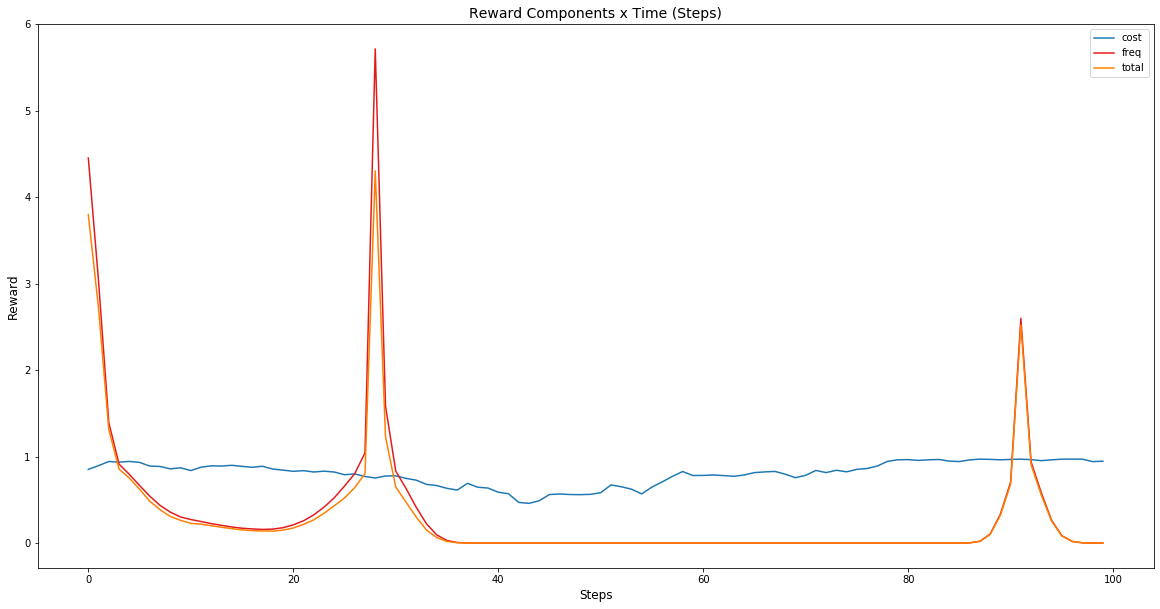

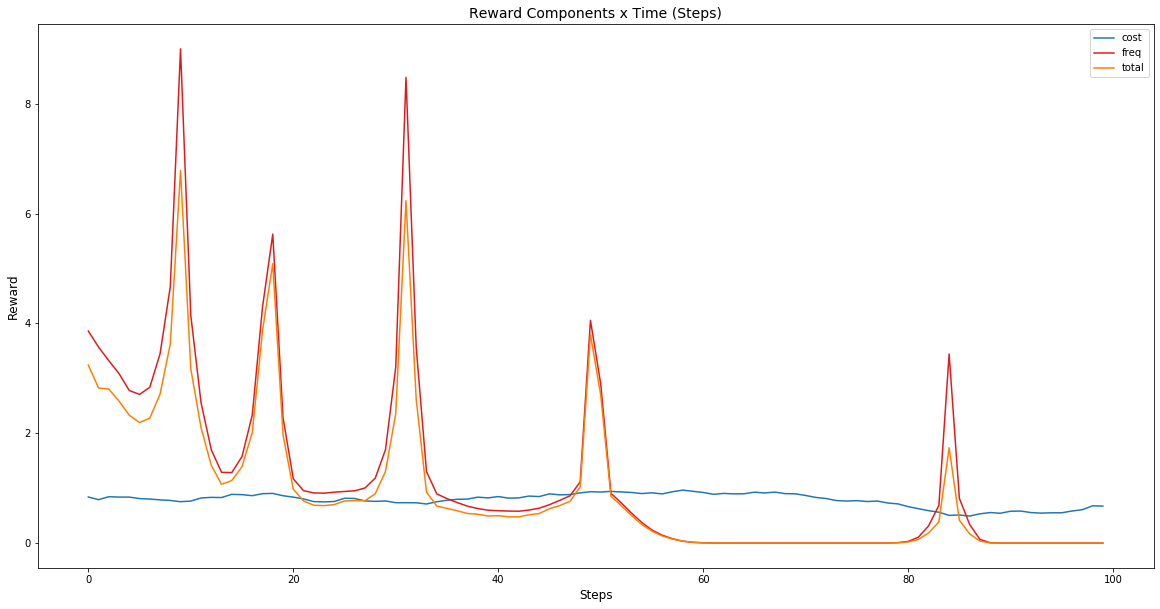

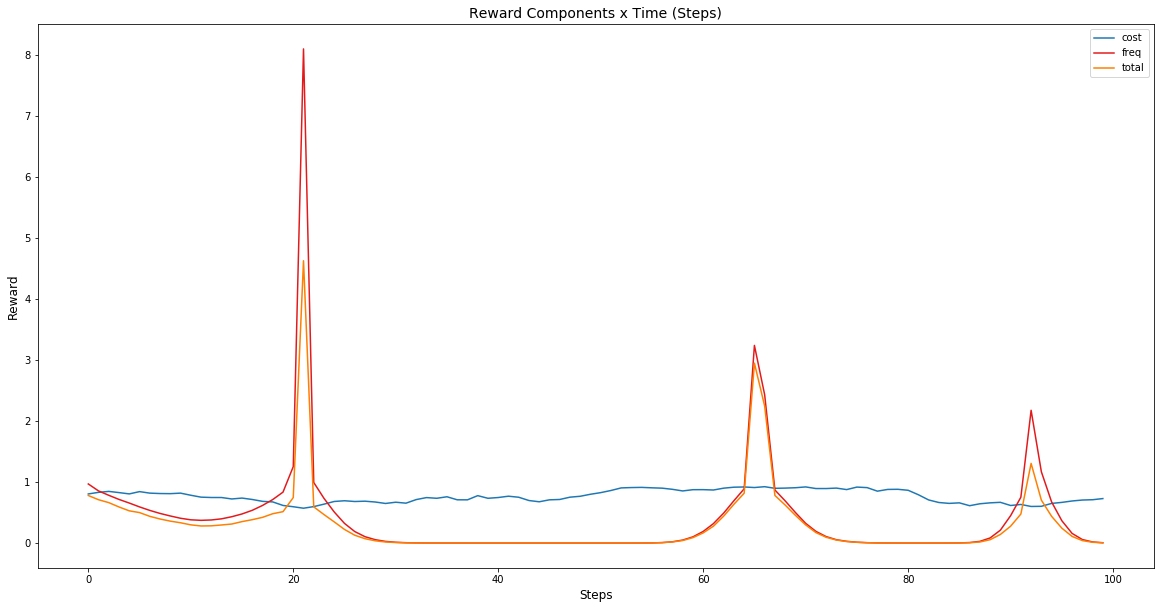

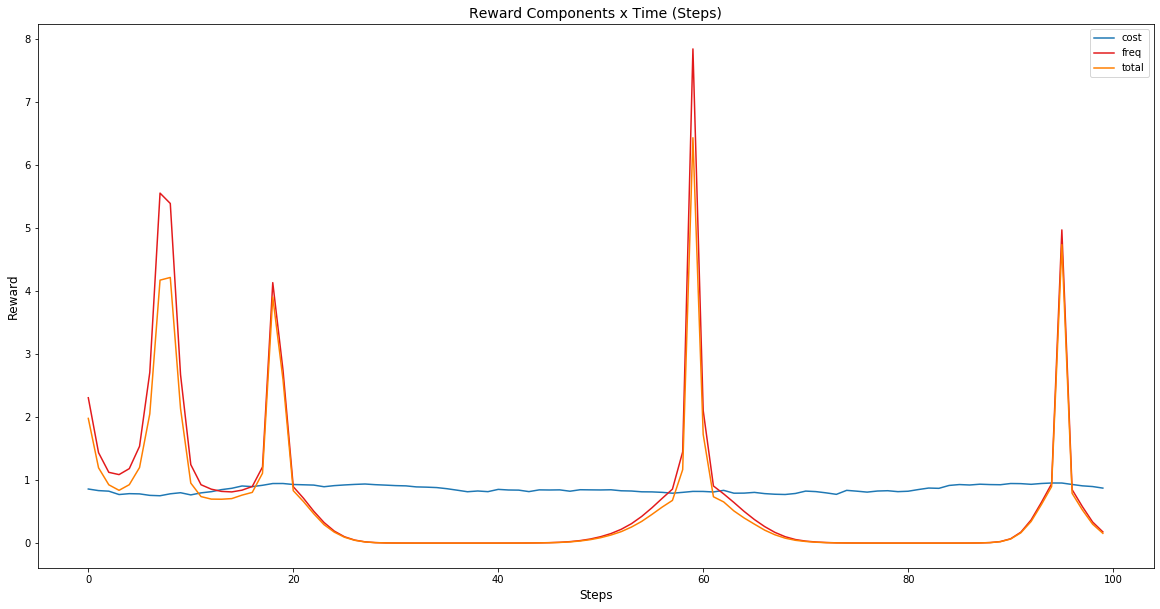

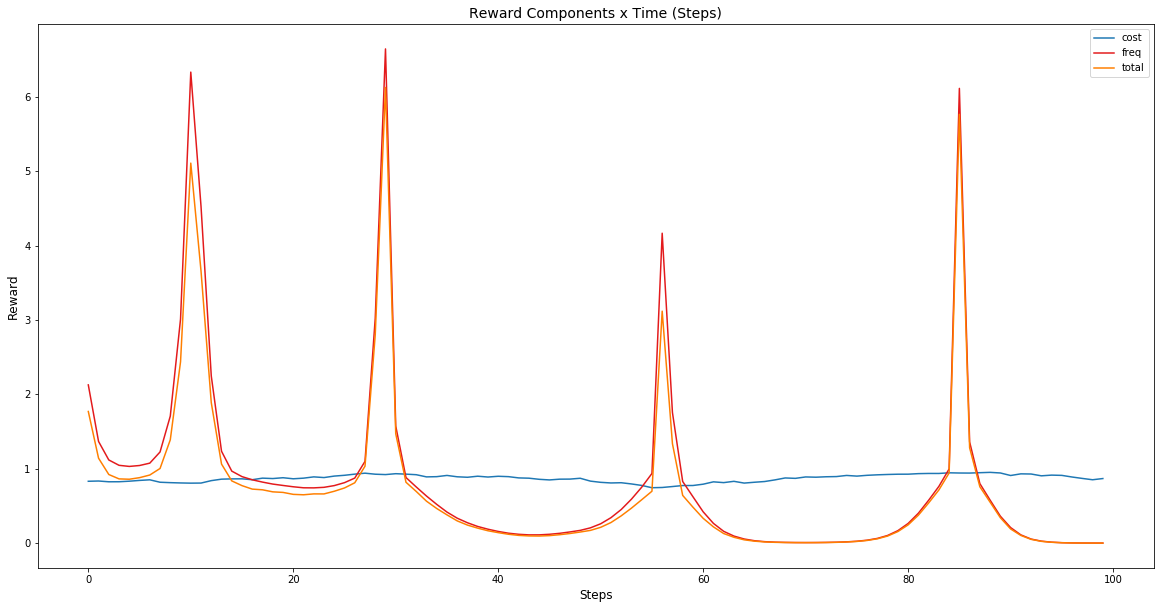

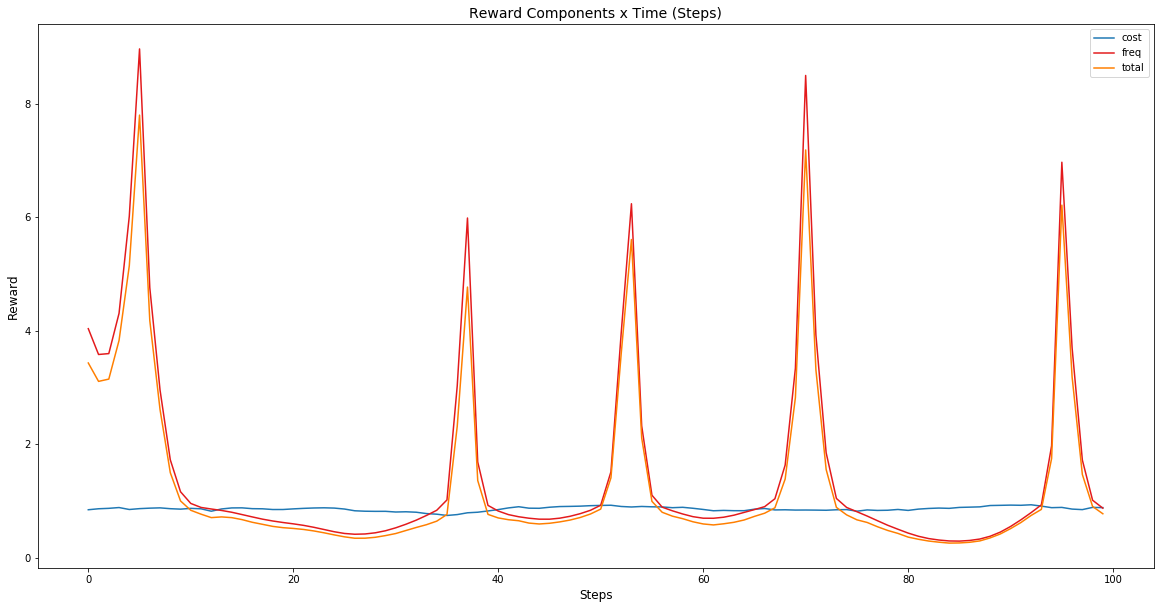

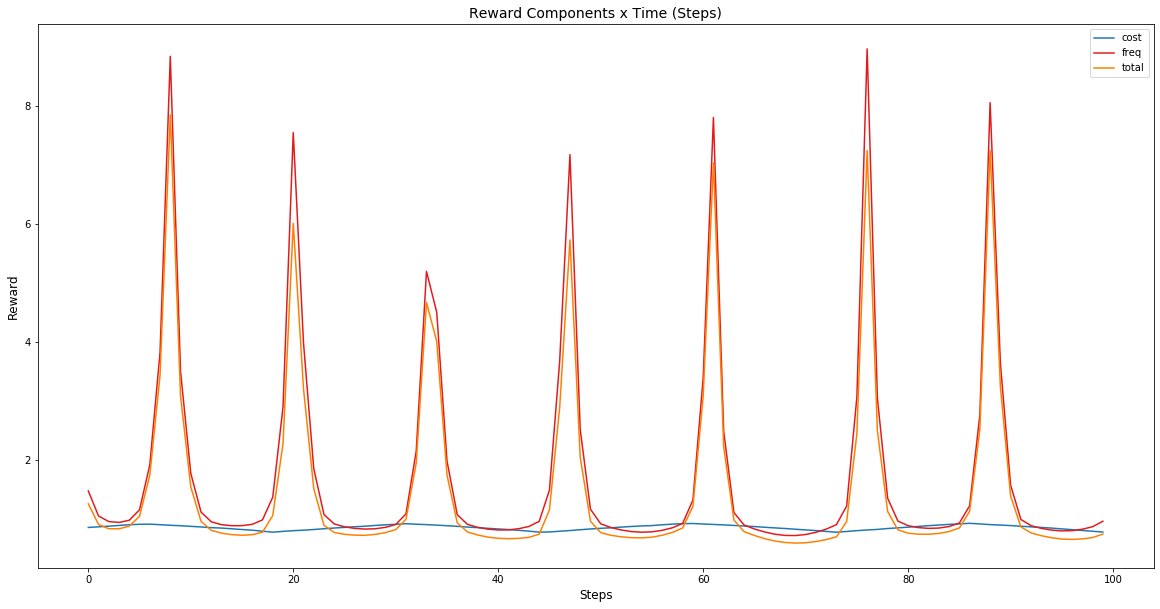

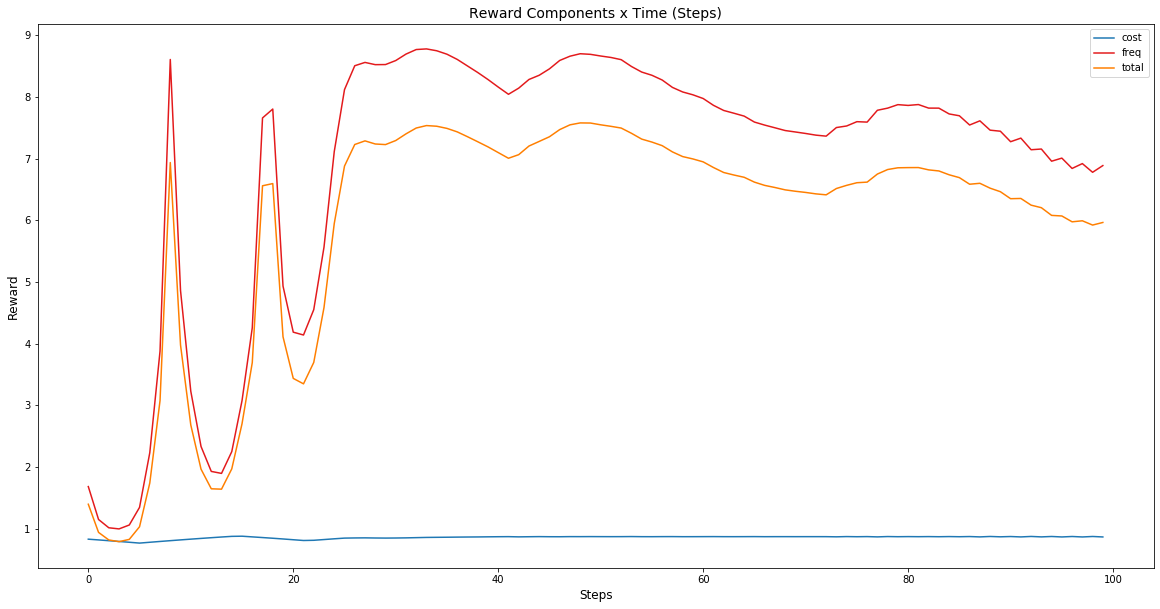

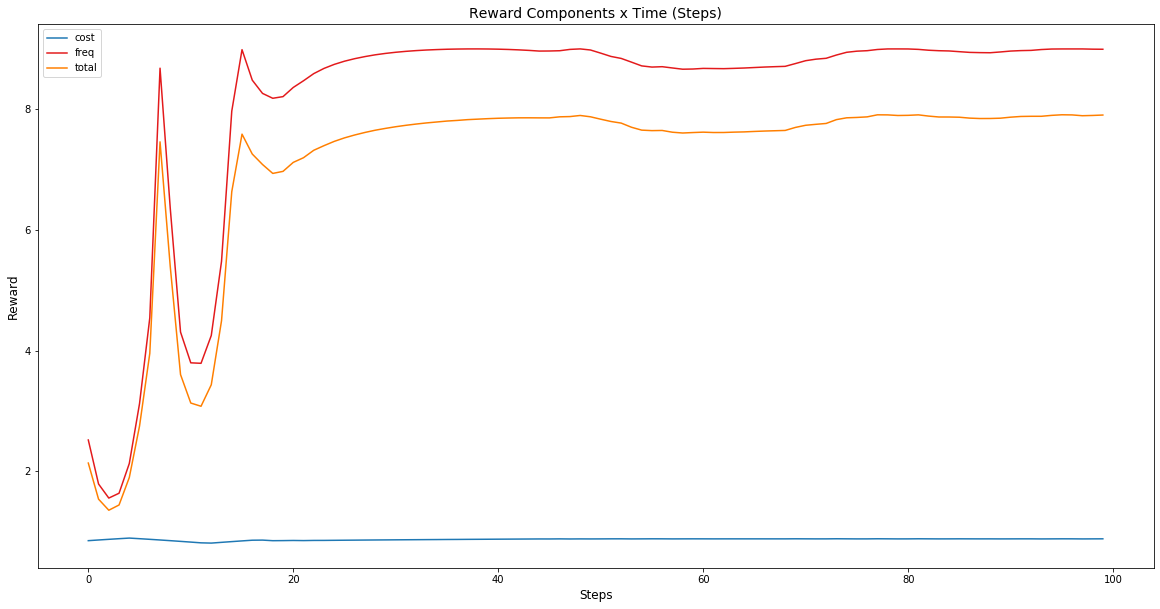

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

2228.558897510577

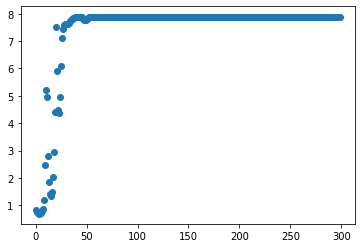

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

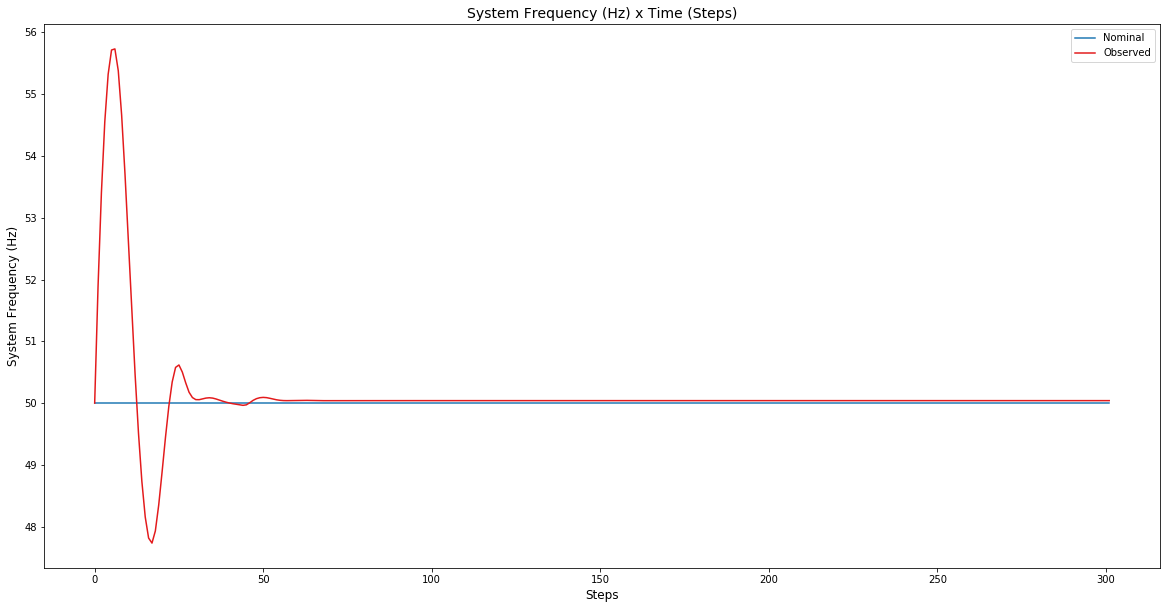

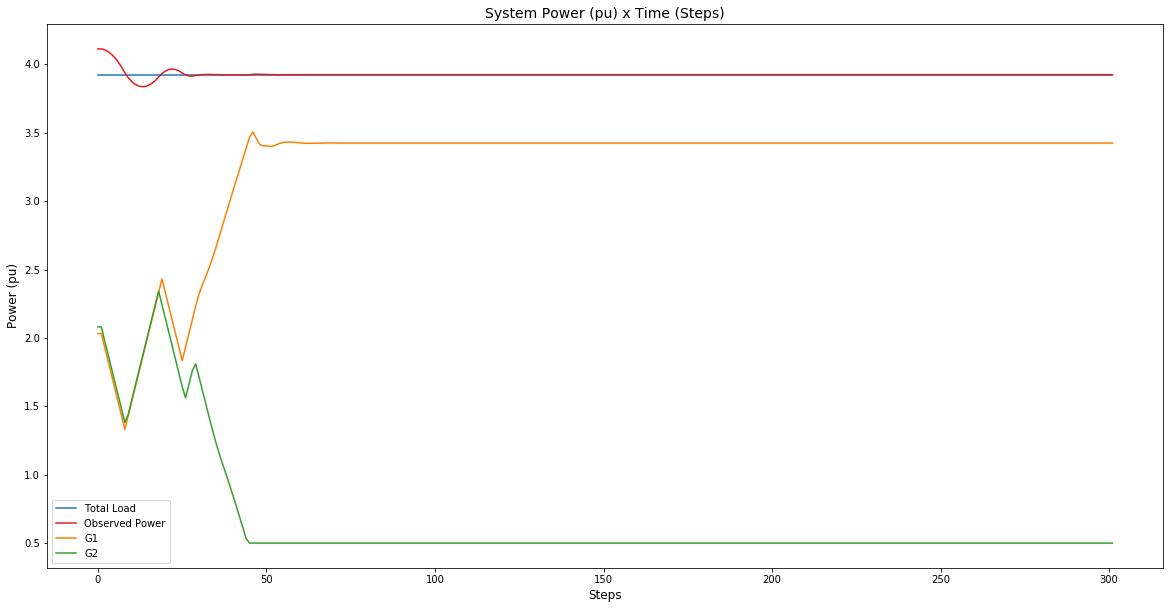

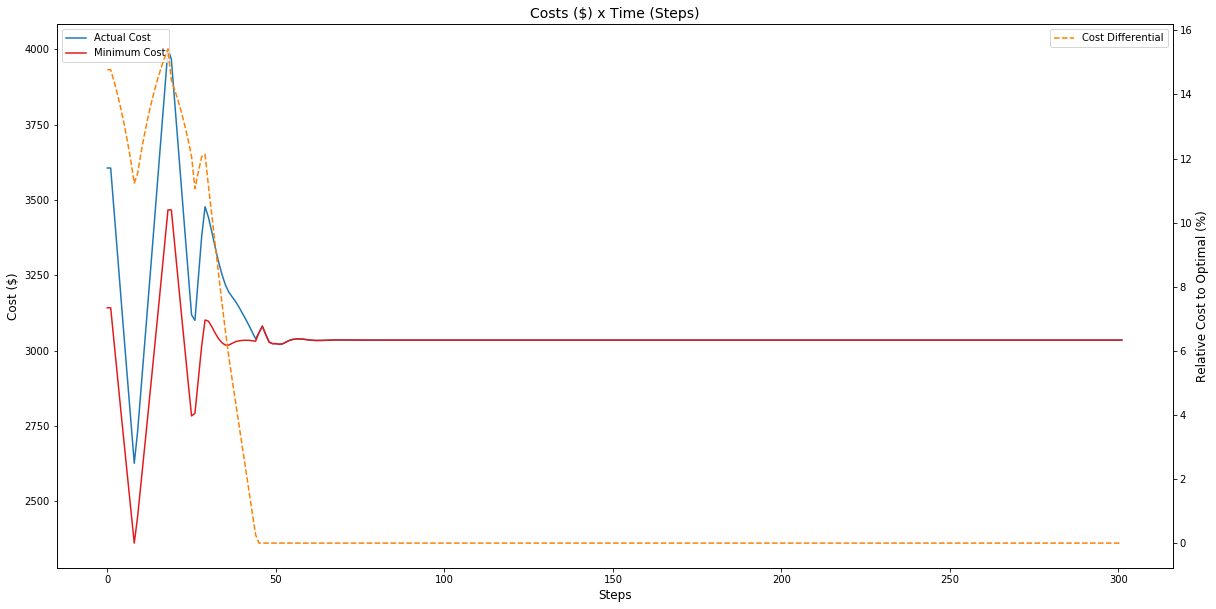

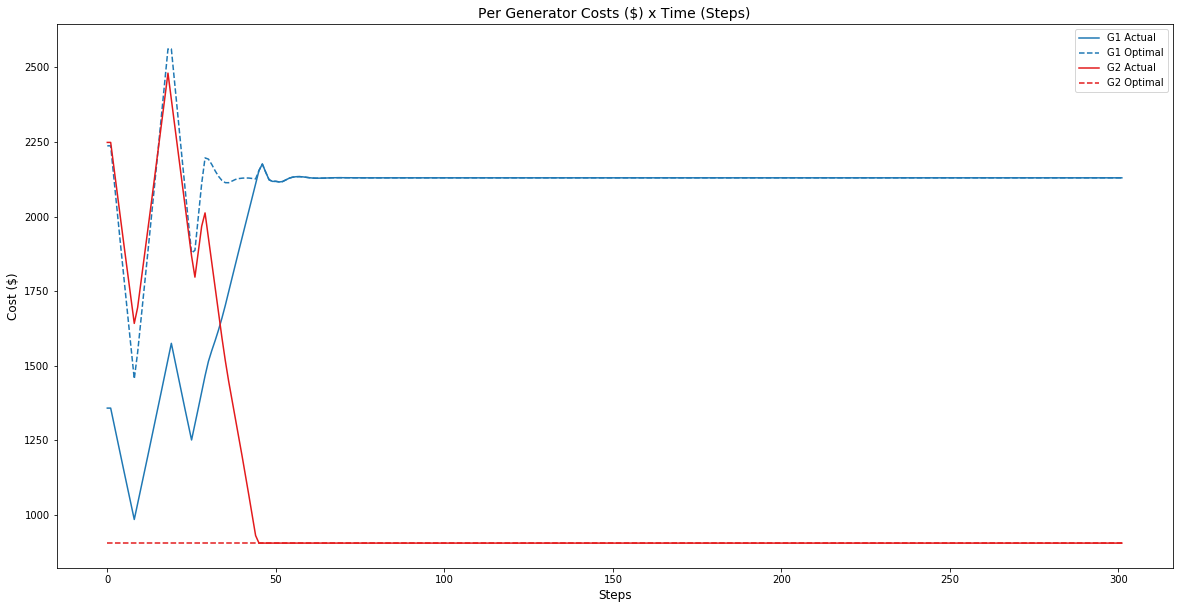

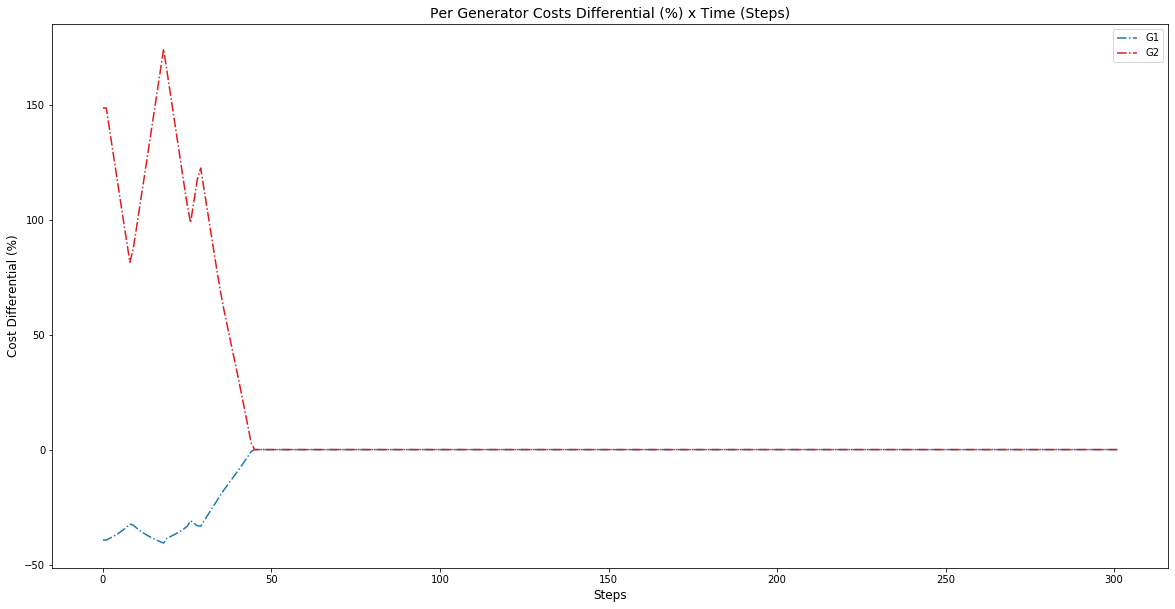

In [13]:
plotAll(electricalSystem.systemHistory)

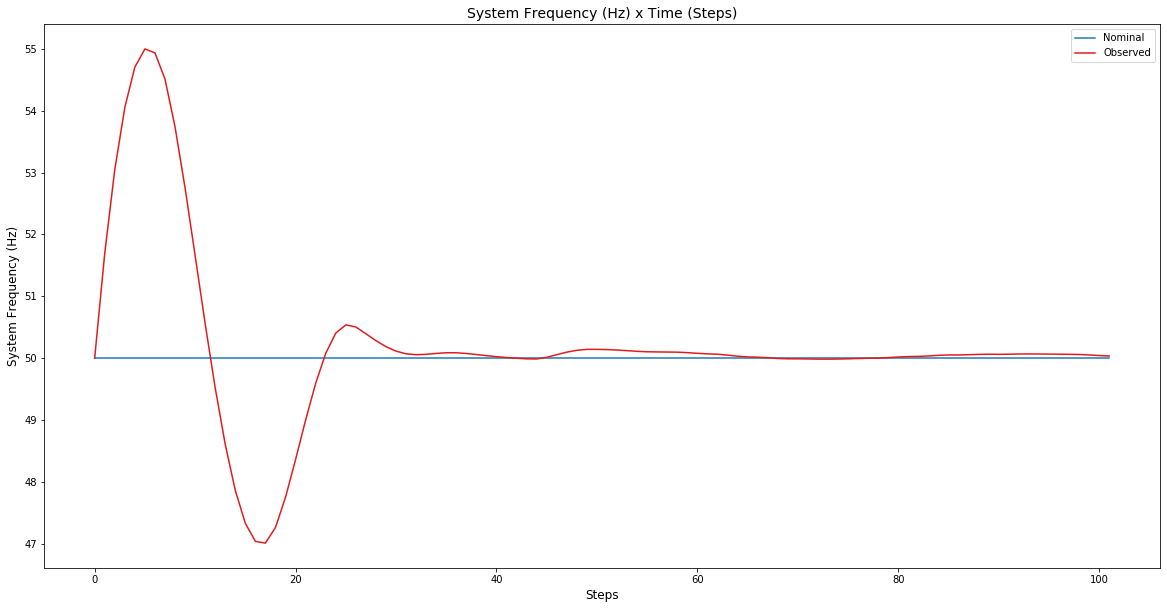

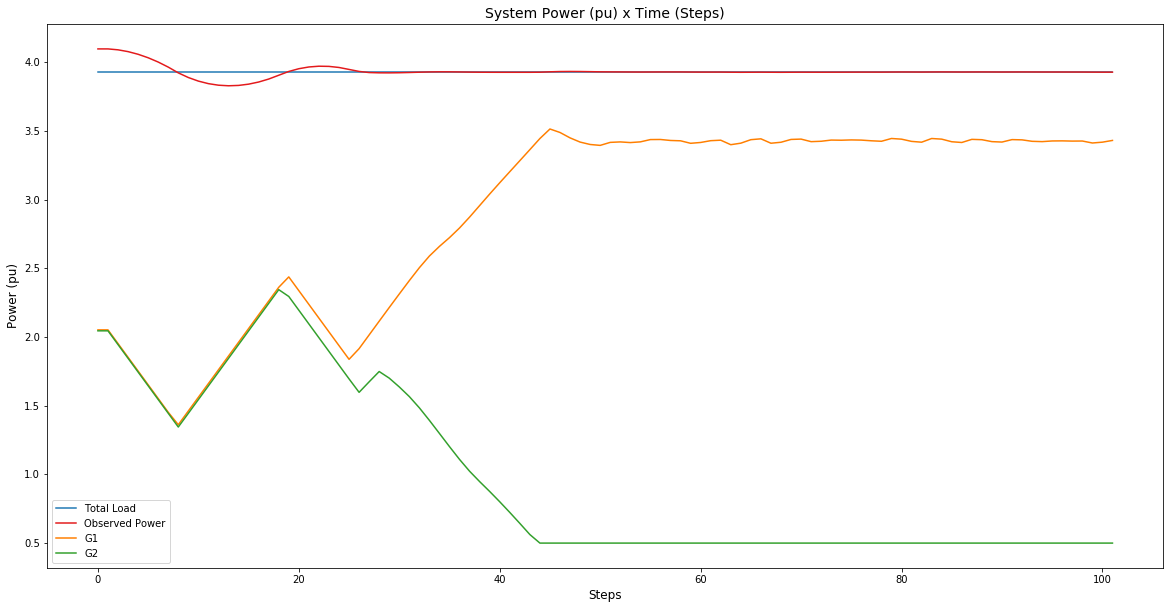

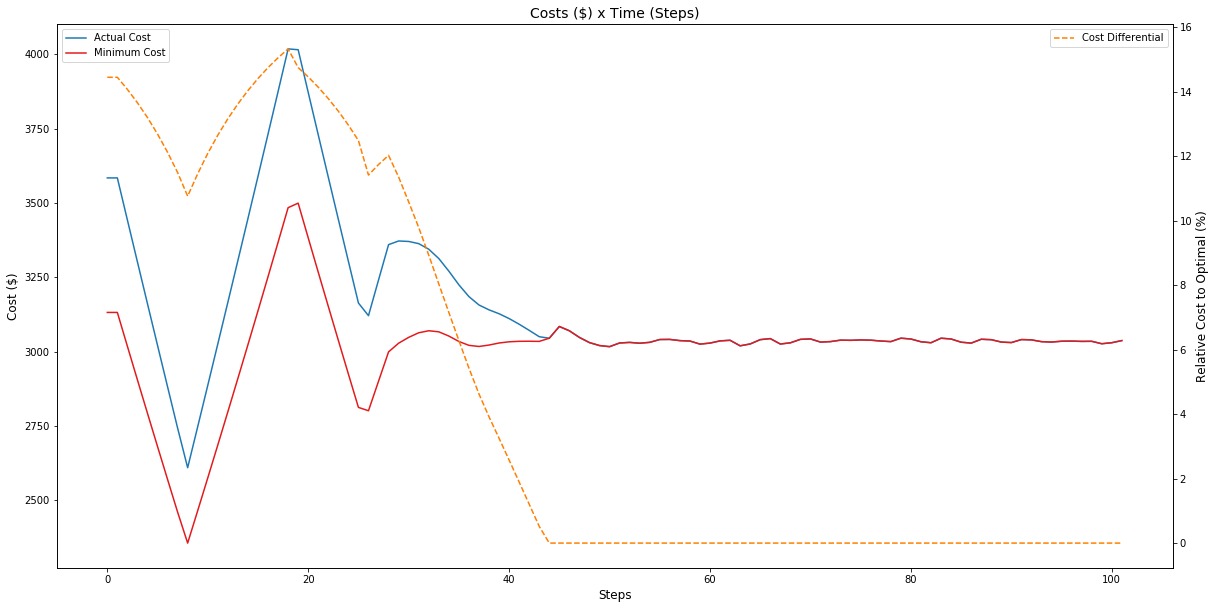

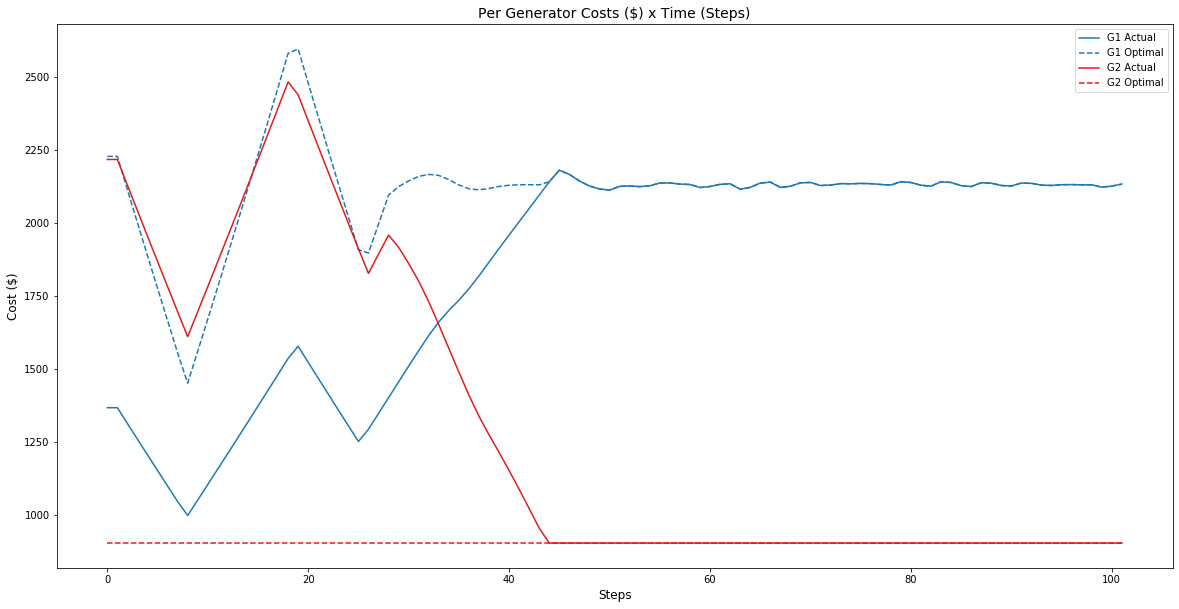

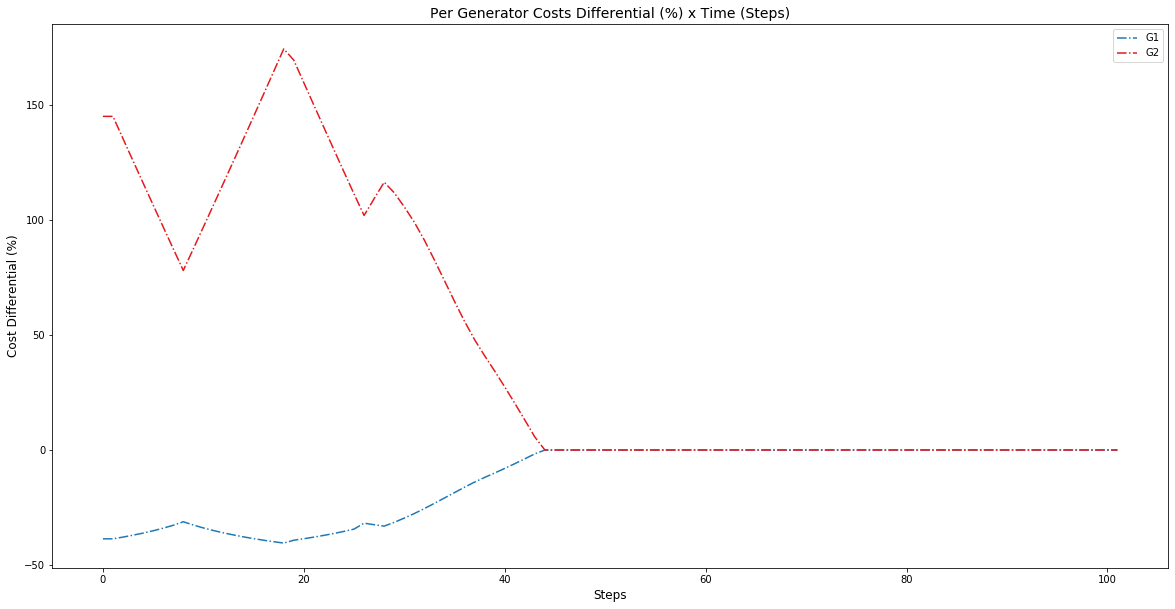

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.8528768202857004,
   'freq': 4.455008349800626,
   'total': 3.7995733557242035},
  {'cost': 0.895858569242005,
   'freq': 3.030399012121221,
   'total': 2.7148089232313026},
  {'cost': 0.9437689886915959,
   'freq': 1.3933694293456889,
   'total': 1.3150188572073669},
  {'cost': 0.9362285781618334,
   'freq': 0.9139156291926154,
   'total': 0.8556339300788797},
  {'cost': 0.9447856060135185,
   'freq': 0.796018547019869,
   'total': 0.7520668653441673},
  {'cost': 0.9337438743492373,
   'freq': 0.6667060228136319,
   'total': 0.6225326647939716},
  {'cost': 0.8908645573837647,
   'freq': 0.543205117184022,
   'total': 0.4839221862887398},
  {'cost': 0.8867093518719751,
   'freq': 0.43632418050805266,
   'total': 0.386892731304366},
  {'cost': 0.8588274696464057,
   'freq': 0.3583668556366019,
   'total': 0.3077752998315216},
  {'cost': 0.8710594771006789,
   'freq': 0.30235249279974086,
   'total': 0.26336700427822907},
  {'cost': 0.8392747853967897,
   'freq': 0.272625184

TypeError: float() argument must be a string or a number, not 'dict'

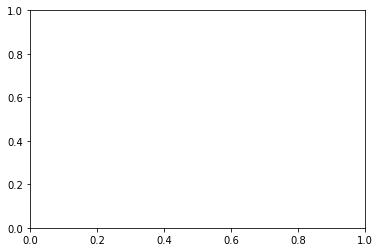

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()